# Homework

## 3. Implementation

### 3.1. Data Processing

1. The first cells of the notebook are the same as in the TP on text convolution. Apply the same preprocessing to get a dataset (with the same tokenizer) with a train and a validation split, with two columns review_ids (list of int) and label (int).

**ANSWER** : Copying what we did in the TP on text convolution.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from tabulate import tabulate
from datasets import load_dataset

from tqdm import tqdm
from transformers import BertTokenizer

import functools
from typing import Any

c:\Users\huang\Desktop\M2IASD\NLP\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Version de pytorch : ", torch.__version__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

Version de pytorch :  2.3.0+cu121


device(type='cuda')

In [3]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [5]:
print("Type of the tokenizer:", type(tokenizer.vocab))
VOCSIZE = len(tokenizer.vocab)
print("Length of the vocabulary:", VOCSIZE)
print(str(tokenizer.vocab)[:50])

Type of the tokenizer: <class 'collections.OrderedDict'>
Length of the vocabulary: 30522
OrderedDict({'[PAD]': 0, '[unused0]': 1, '[unused1


In [6]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding='max_length',
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

In [7]:
n_samples = 5000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle(seed=0)

# Select 5000 samples
sampled_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
sampled_dataset = sampled_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer" : tokenizer}
)

In [8]:
# Remove useless columns
sampled_dataset = sampled_dataset.select_columns(['review_ids','label'])

# Split the train and validation
splitted_dataset = sampled_dataset.train_test_split(test_size=0.2)

document_train_set = splitted_dataset['train']
document_valid_set = splitted_dataset['test']

2. Write a function extract_words_contexts. It should retrieve all pairs of valid $(w, C^+)$ from a list of ids representing a text document. It takes the radius $R$ as an argument. Its output is therefore two lists :

to make sure that every C has the same size, we add padding at the beginning and the end of the sentence. For example the first word of the sentence, will have R paddings corresponding to the R tokens that should be before. We can also use the token itself, so that it has a high dot product with itself.

In [9]:
tokenizer.pad_token_id

0

In [10]:
def extract_words_contexts(sample, R):
    token_ids = sample["review_ids"]
    n_tokens = len(token_ids)
    positive_context = []
    token_ids_with_padding = [0]*R + token_ids + [0]*R
    for i in range(n_tokens) :
        # if out of bounds
        if i<R or i>=n_tokens-R :
            positive_context.append([token_ids_with_padding[i+r] for r in range(R)] + [token_ids_with_padding[i+R+r] for r in range(1,R+1, 1)])
        else :
            positive_context.append([token_ids[i+r] for r in range(-R, 0, 1)] + [token_ids[i+r] for r in range(1, R+1, 1)])
    return token_ids, positive_context

In [11]:
toto, test = extract_words_contexts(document_train_set[2], 3)

In [12]:
print("First 5 tokens :", toto[:5])
print("C+ of the first 5 tokens :")
test[:5]

First 5 tokens : [2065, 15555, 22308, 2020, 2025]
C+ of the first 5 tokens :


[[0, 0, 0, 15555, 22308, 2020],
 [0, 0, 2065, 22308, 2020, 2025],
 [0, 2065, 15555, 2020, 2025, 2525],
 [2065, 15555, 22308, 2025, 2525, 3459],
 [15555, 22308, 2020, 2525, 3459, 2004]]

3. Write a function flatten_dataset_to_list that applies the function extract_words_contexts on a whole dataset.

In [13]:
def flatten_dataset_to_list(dataset, R):
    '''takes a dataset and returns the token_ids and positive context'''
    token_ids = []
    positive_contexts = []
    for sample in dataset:
        sample_token_ids, positive_context = extract_words_contexts(sample, R)
        token_ids.append(sample_token_ids)
        positive_contexts.append(positive_context)
    return token_ids, positive_contexts

4. Apply the function to your initial document_train_set and document_valid_set, and get the corresponding flattened lists.

In [14]:
R = 2
token_ids, positive_contexts = flatten_dataset_to_list(document_train_set, R)

5. Embed these lists in two valid PyTorch Dataset, like in HW 1, call them train_set and valid_set.

In [15]:
class CustomDataset(Dataset):

    def __init__(self, document_set, R):
        self.document_set = document_set
        token_ids, positive_contexts = flatten_dataset_to_list(document_set, R)
        self.token_ids = torch.tensor(token_ids)
        self.positive_contexts = torch.tensor(positive_contexts)

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, idx):
        return {
            "word_id" : self.token_ids[idx], 
            "positive_context_ids" : self.positive_contexts[idx],
            # "label" : torch.tensor(self.document_set[idx]["label"])
        }

In [16]:
train_set = CustomDataset(document_train_set, R)
valid_set = CustomDataset(document_valid_set, R)

In [17]:
len(valid_set), len(train_set)

(1000, 4000)

In [18]:
try :
    valid_set[951], train_set[1347:-2000]
except :
    print("error")

6. Write a collate_fn function that adds the negative context to the batch. It should be parametrized by the scaling factor K.

In [19]:
def collate_fn(batch, R, K, VOCSIZE):
    ''' batch is a list of dictionary with keys "word_id", "positive_context_ids" and "label" which contain tensors
    What we want is that the output becomes a dictionary with keys :
    - "word_id", which contains the all the token_ids for every review in the batch. It should be a tensor of shape (batch_size, n_tokens=256)
    - "positive_context_ids", which contains the positive context of all tokens for every review in the batch. 
      It should be a tensor of shape (batch_size, n_tokens, 2R)
    - "negative_context_ids", same thing for negative context. It should be a tensor of shape (batch_size, n_tokens, 2RK)
    '''
    batch_size = len(batch)
    n_tokens = len(batch[0]["word_id"])
    result = dict()
    result["word_id"] = torch.stack([review["word_id"] for review in batch])
    result["positive_context_ids"] = torch.stack([review["positive_context_ids"] for review in batch])
    # sample 2RK tokens from the vocabulary for each token in each review in the batch -> reshape it -> convert to a tensor
    result["negative_context_ids"] = torch.tensor(
        np.random.choice(np.arange(VOCSIZE), 2*R*K*n_tokens*batch_size, replace=True)\
            .reshape(batch_size, n_tokens, 2*R*K)
    )
    return result

7. Wraps everything in a DataLoader, like in HW 1.

In [20]:
batch_size = 32
R = 2
K = 2
collate_fn_with_params = functools.partial(collate_fn, R=R, K=K, VOCSIZE=VOCSIZE)

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=collate_fn_with_params
)   
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=collate_fn_with_params
)
n_valid = len(valid_set)
n_train = len(train_set)

8. Make 2 or 3 three iterations in the DataLoader and print R, K and the shapes of all the tensors in the batches (let the output be visible).

In [21]:
print("R =", R)
print("K =", K)

for i, batch in enumerate(train_dataloader):
    print(f"batch {i} :")
    print(batch.keys())
    for key, value in batch.items():
        print(f"'{key}' shape :", value.shape)
    print("-"*50)
    
    if i > 2:
        break

R = 2
K = 2
batch 0 :
dict_keys(['word_id', 'positive_context_ids', 'negative_context_ids'])
'word_id' shape : torch.Size([32, 256])
'positive_context_ids' shape : torch.Size([32, 256, 4])
'negative_context_ids' shape : torch.Size([32, 256, 8])
--------------------------------------------------
batch 1 :
dict_keys(['word_id', 'positive_context_ids', 'negative_context_ids'])
'word_id' shape : torch.Size([32, 256])
'positive_context_ids' shape : torch.Size([32, 256, 4])
'negative_context_ids' shape : torch.Size([32, 256, 8])
--------------------------------------------------
batch 2 :
dict_keys(['word_id', 'positive_context_ids', 'negative_context_ids'])
'word_id' shape : torch.Size([32, 256])
'positive_context_ids' shape : torch.Size([32, 256, 4])
'negative_context_ids' shape : torch.Size([32, 256, 8])
--------------------------------------------------
batch 3 :
dict_keys(['word_id', 'positive_context_ids', 'negative_context_ids'])
'word_id' shape : torch.Size([32, 256])
'positive_conte

### 3.2 Model

9. Write a model named Word2Vec which is a valid torch.nn.Module (i.e.,
write a class that inherits from the torch.nn.Module), and implement the
Word2Vec model. It should be parametrized by the vocabulary size and
the embeddings dimension. Use the module torch.nn.Embedding.

We decided to that model should directly output the similarity, not just the embeddings :

In [22]:
class Word2Vec(torch.nn.Module):

    def __init__(self, VOCSIZE, emb_dim, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.VOCSIZE = VOCSIZE
        self.emb_dim = emb_dim
        self.emb = torch.nn.Embedding(self.VOCSIZE, self.emb_dim, padding_idx=0)
    
    def similarity(self, word_emb, context_emb) -> Any:
        '''Takes the word embeddings, the context_embeddings and compute the dot product between each word embedding and its context embeddings
        word_emb : (B,L,E) = (batch_size, max_length, embedding_dim)
        context_emb : (B,L,C,E)
        output : (B,L,C)
        '''
        word_emb_expanded = word_emb.unsqueeze(2) # (B,L,E) -> (B,L,1,E)
        context_emb_transposed = context_emb.transpose(-1,-2) #(B,L,C,E) -> (B,L,E,C)
        return torch.matmul(word_emb_expanded, context_emb_transposed).squeeze(2) # (B,L,1,E) @ (B,L,E,C) -> (B,L,1,C) -> squeezed into (B,L,C)
    
    def __call__(self, input:dict):
        embeddings = dict()
        for k,v in input.items():
            embeddings[k] = self.emb(v)
        positive_similarity = self.similarity(embeddings["word_id"], embeddings["positive_context_ids"])
        negative_similarity = self.similarity(embeddings["word_id"], embeddings["negative_context_ids"])
        return {"positive_similarity":positive_similarity, "negative_similarity":negative_similarity}

**Quick sanity check**

In [23]:
EMB_DIM = 50
VOCSIZE = tokenizer.vocab_size
model = Word2Vec(VOCSIZE, EMB_DIM)

In [24]:
out = model(batch)
out.keys()

dict_keys(['positive_similarity', 'negative_similarity'])

In [25]:
out["positive_similarity"].shape, out["negative_similarity"].shape

(torch.Size([32, 256, 4]), torch.Size([32, 256, 8]))

**10. Train the model. The training should be parametrized by the batch size B, and the number of epochs E.**

If we denote $y = \mathbb{1}_{c \in \mathcal{C}^+}$, then our loss can be seen as a binary cross-entropy loss :
$$ \frac{1}{n} \sum_{i=1}^n - [y_i \log(x_i) + (1-y_i) \log(1-x_i)]$$ 
where $x_i$ is $\sigma(w_i \cdot c_i)$, (and reduce = 'mean'). <br>
Therefore we can use the torch module BCEWithLogitLoss :

In [26]:
class CustomLoss(nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.BCELoss = nn.BCEWithLogitsLoss()

    def __call__(self, positive_similarity, negative_similarity):
        '''computes the loss'''
        # Positive context
        y_positive = torch.ones_like(positive_similarity, dtype=torch.float32)
        loss = self.BCELoss(positive_similarity, y_positive)

        # Negative context
        y_negative = torch.zeros_like(negative_similarity, dtype=torch.float32)
        loss += self.BCELoss(negative_similarity, y_negative)
        return loss

Sanity check

In [27]:
MyLoss = CustomLoss()

In [28]:
MyLoss(**out)

tensor(4.7726, grad_fn=<AddBackward0>)

Let's implement the training function

In [29]:
model.to(DEVICE)

Word2Vec(
  (emb): Embedding(30522, 50, padding_idx=0)
)

In [30]:
def validation(model, valid_dataloader, loss_fn):
    model.eval()
    loss_total = 0.
    acc = 0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            output = model(batch)
            loss = loss_fn(**output)
            loss_total += loss.detach().cpu().item()
            total_predictions = output["positive_similarity"].shape.numel() + output["negative_similarity"].shape.numel()
            acc += ((torch.sum(output["positive_similarity"]>0)+torch.sum(output["negative_similarity"]<=0))/total_predictions).cpu().item()
    return loss_total / len(valid_dataloader), acc / len(valid_dataloader)

validation(model, valid_dataloader, MyLoss)

100%|██████████| 32/32 [00:00<00:00, 62.95it/s]


(4.9726331532001495, 0.5337619930505753)

In [31]:
def training(model, lr, E, B, loss_fn, train_dataloader, valid_dataloader, writer):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Performance metric tracking
    list_val_acc = []
    list_train_acc = []
    list_train_loss = []
    list_val_loss = []

    for e in range(E):
        # ========== Training ==========
        model.train()
        train_loss = 0.
        acc = 0.
        for batch in tqdm(train_dataloader):
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            optimizer.zero_grad()
            output = model(batch)
            loss = loss_fn(**output)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().item()
            total_predictions = output["positive_similarity"].shape.numel() + output["negative_similarity"].shape.numel()
            acc += ((torch.sum(output["positive_similarity"]>0)+torch.sum(output["negative_similarity"]<=0))/total_predictions).cpu().item()
        list_train_loss.append(train_loss / len(train_dataloader))
        list_train_acc.append(100 * acc / len(train_dataloader))

        # ========== Validation ==========
        l, a = validation(model, valid_dataloader, loss_fn)
        list_val_loss.append(l)
        list_val_acc.append(a * 100)
        # Tensorboard
        writer.add_scalar("Train loss", list_train_loss[-1], e)
        writer.add_scalar("Val loss", l, e)
        writer.add_scalar("Train acc", list_train_acc[-1], e)
        writer.add_scalar("Val acc", a, e)
        print(
            e,
            "\n\t - Train loss: {:.4f}".format(list_train_loss[-1]),
            "Train acc: {:.4f}".format(list_train_acc[-1]),
            "Val loss: {:.4f}".format(l),
            "Val acc:{:.4f}".format(a * 100),
        )
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [32]:
model.to(DEVICE)

Word2Vec(
  (emb): Embedding(30522, 50, padding_idx=0)
)

In [33]:
E = 10
lr = 5e-4
B=32
writer = SummaryWriter("runs/TestWord2Vec")
list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model=model, 
    lr=lr,
    E=E, 
    B=B, 
    loss_fn=MyLoss, 
    train_dataloader=train_dataloader, 
    valid_dataloader=valid_dataloader,
    writer=writer
)

100%|██████████| 32/32 [00:00<00:00, 470.39it/s]


0 
	 - Train loss: 4.7808 Train acc: 53.6133 Val loss: 4.6216 Val acc:53.8432


100%|██████████| 32/32 [00:00<00:00, 501.92it/s]


1 
	 - Train loss: 4.4525 Train acc: 54.1924 Val loss: 4.3307 Val acc:54.6324


100%|██████████| 32/32 [00:00<00:00, 479.96it/s]


2 
	 - Train loss: 4.1755 Train acc: 54.9755 Val loss: 4.0723 Val acc:55.2553


100%|██████████| 32/32 [00:00<00:00, 467.70it/s]


3 
	 - Train loss: 3.9257 Train acc: 55.5758 Val loss: 3.8388 Val acc:55.7857


100%|██████████| 32/32 [00:00<00:00, 486.25it/s]


4 
	 - Train loss: 3.7024 Train acc: 56.3578 Val loss: 3.6394 Val acc:56.6300


100%|██████████| 32/32 [00:00<00:00, 493.61it/s]


5 
	 - Train loss: 3.5063 Train acc: 57.1039 Val loss: 3.4510 Val acc:57.3222


100%|██████████| 32/32 [00:00<00:00, 538.08it/s]


6 
	 - Train loss: 3.3223 Train acc: 57.8958 Val loss: 3.2763 Val acc:58.1180


100%|██████████| 32/32 [00:00<00:00, 435.71it/s]


7 
	 - Train loss: 3.1515 Train acc: 58.6698 Val loss: 3.1175 Val acc:58.9888


100%|██████████| 32/32 [00:00<00:00, 532.70it/s]


8 
	 - Train loss: 2.9898 Train acc: 59.5837 Val loss: 2.9672 Val acc:59.7988


100%|██████████| 32/32 [00:00<00:00, 487.56it/s]

9 
	 - Train loss: 2.8404 Train acc: 60.4203 Val loss: 2.8236 Val acc:60.6061


**11. Validates its accuracy on the test set.**

In [34]:
validation(model, valid_dataloader, MyLoss)

100%|██████████| 32/32 [00:00<00:00, 424.10it/s]


(2.8234601840376854, 0.6060091890394688)

There is no sign of overfitting yet, the model clearly hasn't finished training yet !
Let's take a look at the dot product of a few tokens :

In [70]:
def test_similarity(model, w, Cplus, Cminus):
    token1_id = tokenizer.convert_tokens_to_ids(w)
    token2_id = tokenizer.convert_tokens_to_ids(Cplus)
    R = len(token2_id) if isinstance(token2_id, list) else 1
    token3_id = tokenizer.convert_tokens_to_ids(Cminus)
    RK = len(token3_id) if isinstance(token3_id, list) else 1
    model_input = {
        "word_id":torch.tensor([token1_id]).view(1,1,1).cuda(), 
        "positive_context_ids":torch.tensor([token2_id]).view(1,1,R).cuda(),
        "negative_context_ids":torch.tensor([token3_id]).view(1,1,RK).cuda()
    }
    # print(model_input)
    with torch.no_grad():
        return model(model_input)

test_similarity(model, "I", ["am"], "earth")

{'positive_similarity': tensor([[[[-5.4205]]]], device='cuda:0'),
 'negative_similarity': tensor([[[[-5.4819]]]], device='cuda:0')}

In [36]:
test_similarity(model, "good", "movie", "random")

{'positive_similarity': tensor([[[[8.2870]]]], device='cuda:0'),
 'negative_similarity': tensor([[[[4.2378]]]], device='cuda:0')}

Some embeddings seem to be well learned already, some not so much, for example "I" and "earth" have a positive dot product.

**12. Write a function save_model that saves the model’s embeddings in a file.** <br>

In [37]:
def save_model(model, root):
    embeddings = model.emb.weight
    model_filepath = root + f"model_dim-{model.emb_dim}_radius-{R}_ratio-{K}-batch-{B}-epoch-{E}.ckpt"
    torch.save(embeddings, model_filepath)

In [38]:
# save_model(model)

**13. Once you have a working code, you can launch a bigger training, using more documents, if it does not take too much time.**

Let's take the full dataset with 50k reviews

In [39]:
dataset.shuffle(seed=0)
full_dataset = dataset.select_columns(["review", "sentiment"])
full_dataset = full_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer" : tokenizer}
)
splitted_dataset = full_dataset.train_test_split(0.2)
document_train_set = splitted_dataset["train"]
document_valid_set = splitted_dataset["test"]

Hyperparameters : 

In [40]:
R=4
K=2
B=32
E=20
VOCSIZE=tokenizer.vocab_size
D=200

preparing the dataset

In [41]:
train_set = CustomDataset(document_train_set, R)
valid_set = CustomDataset(document_valid_set, R)

In [42]:
collate_fn_with_params = functools.partial(collate_fn, R=R, K=K, VOCSIZE=VOCSIZE)

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=collate_fn_with_params
)   
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=collate_fn_with_params
)
n_valid = len(valid_set)
n_train = len(train_set)

In [43]:
model = Word2Vec(VOCSIZE, D)
model.to(DEVICE)

Word2Vec(
  (emb): Embedding(30522, 200, padding_idx=0)
)

In [44]:
lr=5e-3
writer = SummaryWriter("runs/Word2Vec_v1")

list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model=model, 
    lr=lr,
    E=E, 
    B=B, 
    loss_fn=MyLoss, 
    train_dataloader=train_dataloader, 
    valid_dataloader=valid_dataloader,
    writer=writer
)

100%|██████████| 313/313 [00:01<00:00, 191.21it/s]


0 
	 - Train loss: 2.5815 Train acc: 73.0883 Val loss: 1.3479 Val acc:77.1193


100%|██████████| 313/313 [00:01<00:00, 195.92it/s]


1 
	 - Train loss: 1.1259 Train acc: 78.0768 Val loss: 1.0163 Val acc:78.4000


100%|██████████| 313/313 [00:01<00:00, 193.27it/s]


2 
	 - Train loss: 0.9397 Train acc: 78.7971 Val loss: 0.9148 Val acc:78.8093


100%|██████████| 313/313 [00:01<00:00, 197.30it/s]


3 
	 - Train loss: 0.8745 Train acc: 79.1941 Val loss: 0.8708 Val acc:79.1362


100%|██████████| 313/313 [00:01<00:00, 201.56it/s]


4 
	 - Train loss: 0.8441 Train acc: 79.4370 Val loss: 0.8487 Val acc:79.3310


100%|██████████| 313/313 [00:01<00:00, 196.82it/s]


5 
	 - Train loss: 0.8272 Train acc: 79.6111 Val loss: 0.8372 Val acc:79.4853


100%|██████████| 313/313 [00:01<00:00, 193.79it/s]


6 
	 - Train loss: 0.8165 Train acc: 79.7632 Val loss: 0.8308 Val acc:79.5851


100%|██████████| 313/313 [00:01<00:00, 198.72it/s]


7 
	 - Train loss: 0.8095 Train acc: 79.8662 Val loss: 0.8281 Val acc:79.6396


100%|██████████| 313/313 [00:01<00:00, 197.89it/s]


8 
	 - Train loss: 0.8043 Train acc: 79.9392 Val loss: 0.8270 Val acc:79.6743


100%|██████████| 313/313 [00:01<00:00, 196.77it/s]


9 
	 - Train loss: 0.8004 Train acc: 79.9953 Val loss: 0.8270 Val acc:79.6867


100%|██████████| 313/313 [00:01<00:00, 193.69it/s]


10 
	 - Train loss: 0.7973 Train acc: 80.0428 Val loss: 0.8270 Val acc:79.7000


100%|██████████| 313/313 [00:01<00:00, 189.77it/s]


11 
	 - Train loss: 0.7948 Train acc: 80.0849 Val loss: 0.8269 Val acc:79.7230


100%|██████████| 313/313 [00:01<00:00, 175.23it/s]


12 
	 - Train loss: 0.7930 Train acc: 80.1189 Val loss: 0.8272 Val acc:79.7302


100%|██████████| 313/313 [00:01<00:00, 160.19it/s]


13 
	 - Train loss: 0.7916 Train acc: 80.1388 Val loss: 0.8272 Val acc:79.7399


100%|██████████| 313/313 [00:01<00:00, 180.36it/s]


14 
	 - Train loss: 0.7905 Train acc: 80.1580 Val loss: 0.8274 Val acc:79.7379


100%|██████████| 313/313 [00:01<00:00, 193.46it/s]


15 
	 - Train loss: 0.7896 Train acc: 80.1703 Val loss: 0.8281 Val acc:79.7359


100%|██████████| 313/313 [00:01<00:00, 185.72it/s]


16 
	 - Train loss: 0.7889 Train acc: 80.1871 Val loss: 0.8282 Val acc:79.7377


100%|██████████| 313/313 [00:01<00:00, 191.89it/s]


17 
	 - Train loss: 0.7882 Train acc: 80.2038 Val loss: 0.8286 Val acc:79.7589


100%|██████████| 313/313 [00:01<00:00, 197.83it/s]


18 
	 - Train loss: 0.7877 Train acc: 80.2118 Val loss: 0.8284 Val acc:79.7736


100%|██████████| 313/313 [00:01<00:00, 201.14it/s]

19 
	 - Train loss: 0.7872 Train acc: 80.2239 Val loss: 0.8288 Val acc:79.7770


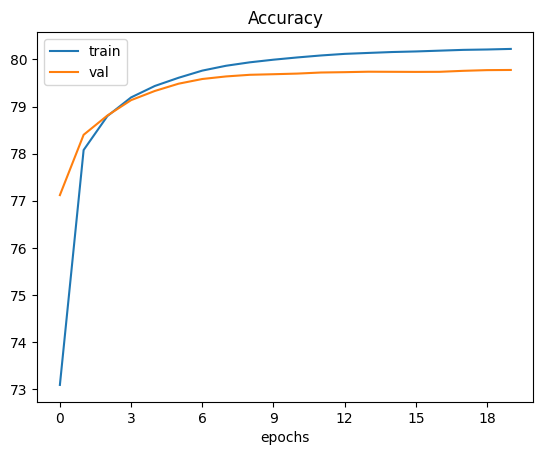

In [46]:
plt.plot(list_train_acc, label="train")
plt.plot(list_val_acc, label="val")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.legend()
plt.xticks(range(0,E,3));

The model performance plateaus at 80% accuracy, it overfits after that.

In [76]:
print(test_similarity(
    model, 
    w="actor", 
    Cplus=["bad","good","terrible","handsome","great","absolutely", "actor"], 
    Cminus=["mathematician","robotic","[PAD]","?","Newton","stochastic"]
))

{'positive_similarity': tensor([[[[3.7371, 3.8635, 3.1721, 2.0185, 4.7882, 2.6421, 9.8530]]]],
       device='cuda:0'), 'negative_similarity': tensor([[[[-1.6685,  0.0181,  0.0000,  2.4596, -5.7207, -5.7207]]]],
       device='cuda:0')}


a good model should have negative values for words in $C^-$ and positive for $C^+$. Interestingly enough, the token "[PAD]", has a null dot product with every word. This is because we used it as a placeholder.

In [75]:
save_model(model, root="runs/Word2Vec_v1/")

Let's try different things : 
- for tokens at the beginning and end of the reviews, we will add the token itself as their positive context instead of "[PAD]". <br>
  For example the review "I liked this movie" should have (for the word "I" and R=2) $C^+ =$  ["I", "I", "I", "liked", "this"]. <br>
  So that the dot product of a token with itself is high. Using "[PAD]" forces tokens at the beginning of the review to have a high similarity with "[PAD]", which is not necessarily what we want.
- Reduce the embedding dimension. As we've seen, there is a little bit of overfitting, reducing the size of the embeddings will simplify the model a little bit and reduce overfitting.
- Reduce the learning rate with a scheduler

In [ ]:
def load_model(model_filepath):
    embeddings_weights = torch.load(model_filepath)
    pass